# MCMC assignment

This demo shows how the Metropolis-Hastings algorithm
with/without annealing can be used to sample from a
mixture of 2 Gaussians if we can sample from a Gaussian
proposal.

You can play and see the effects of the proposal, the
annealing and the cooling schedule. Try to define new
proposals and target functions.

**Author: Ruben Martinez-Cantin**

# How to submit the results

Make a copy of this file in your Drive. Then you can use textboxes to write directly your report. Download as .ipynb and submit that file in Moodle.

In [ ]:
import time
import numpy as np
import matplotlib.pylab as pl

## Target function

First, we define the function that we want to sample from p(x). Note that p(x) can be any arbitrary function, not only a probability distribution. Thus, it might be possible that $$\int p(x) dx \neq 1$$

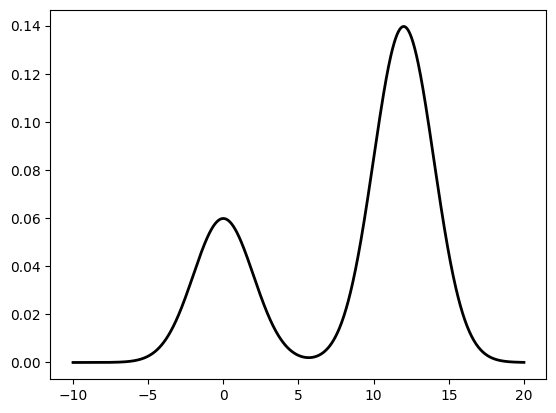

In [ ]:
#Target distribution is a mixture of Gaussians.
def fgaussian(x,sigma):
    return np.exp(-0.5 * (x)**2 / sigma**2)/(np.sqrt(2*np.pi)*sigma)

def fmixture(x):
    sigma = 2      #  Standard deviation of the target components.
    return 0.3*fgaussian(x,sigma) + 0.7*fgaussian(x-12,sigma)

x_t = np.linspace(-10,20,1000)
pl.plot(x_t,fmixture(x_t),'k',linewidth=2)

## Metropolis-Hastings

Now, we define the _Metropolis-Hastings_ function to perform a step of the Markov chain.

First, we need to define the proposal. In this case, we assume that the proposal is a Gaussian distribution centered at the location of the current location:

$$ q(x^*|x^{(i)}) = \mathcal{N}(x^{(i)}, \sigma) $$

We can implement this by considering the proposal as a random *displacement* with zero mean:

$$ x^* = x^{(i)} + z \qquad q(z) = \mathcal{N}(0, \sigma)$$

This is called a *random walk proposal*.
Then, the acceptance ratio is

$$ \alpha = \min \left(1, \frac{p(x^*)q(x^{(i)}|x^*)}{p(x^{(i)})q(x^*|x^{(i)})}\right) $$

but it can be clearly seen that the proposal is simetric $q(x^{(i)}|x^*) = q(x^*|x^{(i)})$. Thus, the ratio can be simplified to:

$$ \alpha = \min \left(1, \frac{p(x^*)}{p(x^{(i)})}\right)$$

Then, we can accept the new point by selecting a random value $u \sim \mathcal{U}(0,1)$ to be compared with the acceptance ratio:

$$
x^{(i+1)} = \begin{cases} x^* \qquad &\text{if} \quad u < \alpha\\
x^{(i)} \qquad &\text{if} \quad u \geq \alpha\\
 \end{cases}
$$



---

### Simulated annealing
(OPTIONAL): In this especific case, we can reconstruct a simplified version of the *simulated annealing* algorithm by raising the acceptance ration to an inverse temperature:

$$
x_{anneal}^{(i+1)} = \begin{cases} x^* \qquad &\text{if} \quad u < \alpha^{1/T}\\
x^{(i)} \qquad &\text{if} \quad u \geq \alpha^{1/T}\\
 \end{cases}
$$

Combined with a cooling schedule, it can be used to optimize a function. Note that MH returns the samples that are distributed according to $p(x)$, while SA is a sampling method to find $x^{opt} = \arg \max p(x)$.

Note that Temp is not defined for Metropolis-Hastings. If you want to implemented simulated annealing, you can start that part by checking the value of `Temp` with:

```
if Temp is not None:
  # code for SA
```

In [ ]:
# Metropolis-Hasting
###################################################################
# MH proposal is a zero mean Gaussian.
def sample_proposal(sigma):
    return sigma * np.random.randn(1)

def mh_step(x, sigma_prop, Temp=None):
    # We sample a move. This is the dynamics/Markov chain part.
    z = sample_proposal(sigma_prop)

    ###############################################################
    # YOUR CODE HERE. COMPUTE THE NEW VALUE FOR X
    ###############################################################

  # Compute proposal
    new_x = z + x

  # Compute acceptance probability
    alpha = min(1, fmixture(new_x) /fmixture(x))

    # Sample from a uniform distribution
    u = np.random.uniform(0, 1)

    ##### SA ####
    if Temp is not None:
      if u < np.power(alpha, (1.0/Temp)):
          return new_x
      else: return x

    ##### MH ####
    else:
      # Accept or reject the proposal
      if u < alpha:
          return new_x
      else: return x

## Slice sampling

This an example of another popular MCMC method.

In the slice sampling algorithm, we _cut_ the target function at a random height $u^{(i+1)} \sim \mathcal{U}\left(0, f(x^{(i)})\right)$. Then, we combine a _step out_ and a _shrink_ phases to compute the width of the slice. Finally, the new sample $x^{(i+1)}$ is generated from the width of the slice.

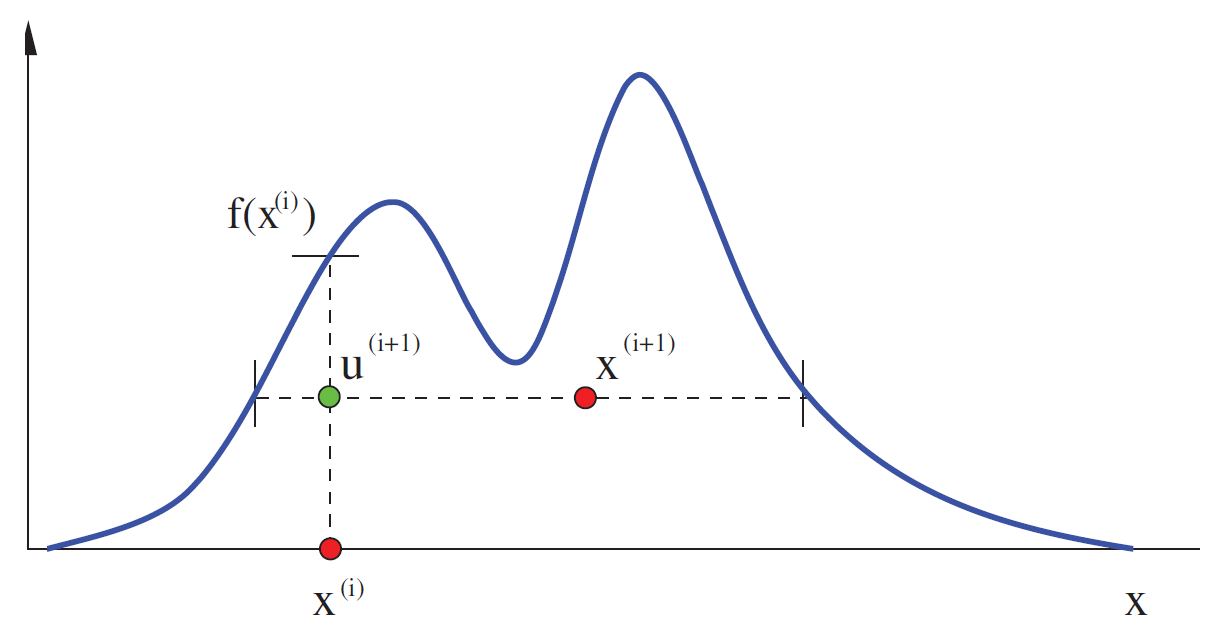

In this case, the standard deviation of the proposal $\sigma$ is used as a step out coefficient. A large coefficient means a faster computation of the slice, but with lower resolution, requiring more time _shrinking_

In [ ]:
# Slice sampling
###################################################################
def sweep(f,x,y,w):
    #step out
    r = np.random.rand(1)
    xl = x - r*w
    xr = x + (1-r)*w

    while f(xl)>y: xl -= w;
    while f(xr)>y: xr += w;

    #shrink
    modified = True
    while modified:
        x_new = (xr-xl) * np.random.rand(1) + xl
        if f(x_new) < y:
            if x_new > x:
                xr = x_new
            elif x_new < x:
                xl = x_new
            else:
                print("Error. Slice colapsed!")
                modified=False
        else:
            modified=False

    return x_new, xl, xr

def slice_step(x,sigma_prop):
    y_max = fmixture(x)
    u = np.random.rand(1)*y_max
    x_new,xl,xr = sweep(fmixture,x,u,sigma_prop)
    return x_new

## Markov Chain Monte Carlo

Finally, we generate the MCMC trajectory based on the corresponding step functions. The _simulated annealing_ algorithm can be computed with a MH step function and a temperature.

In [ ]:
# Main function
def mcmc(sampler,n_samples, sigma_prop):
    #############################################################
    # OPTIONAL: Only for Simulated Annealing
    T_i = 1.0   #1.0            #  Initial temperature (only used for annealing)
    CS = 0.995 #0.995             #  Cooling schedule (only used for annealing)
    #############################################################


    x = np.zeros((n_samples,1))       #  Markov chain (unknowns).
    x[0] = 20*np.random.rand(1)       #  Initial point of the Markov Chain.

    for i in range(1,n_samples):
        if sampler == 'mh':
            # Metropolis-Hastings algorithm
            x[i] = mh_step(x[i-1],sigma_prop)
        elif sampler == 'sa':
            # Simulated annealing algorithm. Version of MH for optimization.
            x[i] = mh_step(x[i-1],sigma_prop,T_i)
            T_i = T_i*CS    # Adjust the cooling schedule.
        elif sampler == 'slice':
            # Slice sampling
            x[i] = slice_step(x[i-1],sigma_prop)
        else:
            print("Error. Sampler not supported.")
            break

    return x

We plot the MCMC samples as an histogram.

In [ ]:
def plot_all(x, spIndex , mcIndex, burnin=0 ):
    N_bins = 50               #  Number of bins in the histogram.
    pl.subplot(spIndex)
    x_t = np.linspace(-10,20,1000)
    n, bins, patches = pl.hist(x[burnin:mcIndex], N_bins,
                               density=True, facecolor='green', alpha=0.75)
    pl.plot(x_t,fmixture(x_t),'k',linewidth=2)
    pl.axis([-10, 20, 0, 0.15])
    plot_name = 'Iteration = %d' % mcIndex
    pl.title(plot_name)
    pl.tight_layout()

## Evaluation of MCMC

We plot 4 snapshots of the trajectory with 100, 500, 1000 and all the samples (5000).

## Your tasks

First, you need to implement the Metropolis-Hastings algorithm. You already have a similar sampler (slice sampling) for comparison of the results.

Then, you can play with the different samplers, the number of iterations, the proposal or even the target function. Write a small comment in a separate text box with your results. Here are some ideas to try and discuss, but you try different things:

Metropolis-Hastings:
*   What happens for small/large values of $\sigma$ for MH?

ANSWER: for large values, the generated moves cover a wider range, thus the space is explored more extensively. However, large steps might lead to lower acceptance rates if the proposed moves fall in regions of low probability density of the target distribution, and it may take more iterations to converge. With small values, the explored space is more narrow, which may cause the algorithm to get stuck in local modes. Also, slower exploration means the need for more iterations to cover the full space. However, acceptance rates should be higher for most proposed moves as the algorithm is likely to stay in regions of higher probability density.

*   What happens if you add a narrow peak to the function?

ANSWER: it would be harder for the algorithm to explore the region corresponding to the peak, as the proposed moves would not likely reach that area. In this case, a fine tuning of sigma is required in order to get an acceptable result and explore the peak efficiently without missing it. The rate of convergence would also be much lower as the algorithm would take more time to explore that area.

*   How does the acceptance work for the MH algorithm? Are there some case where we always accept the new position?

ANSWER:

* The acceptance rate is computed based on the ratio between the probability of the proposed state on the target distribution versus the probability of the current state. The move is accepted with probability alpha. Whenever alpha >= 1, the move is always accepted. This may happen whenever the proposed state is more probable than the current state, when exploring areas of higher probability density.

OPTIONAL (slice sampling and simulated annealing):
*   What is the purpose of the cooling schedule in the Simulated Annealing?

ANSWER: the cooling schedule goal is to reduce the temperature parameter gradually over time. It is crucial to make the algorithm transition between exploration versus exploitation behavior, as it becomes less likely to accept worse solutions as the temperature decreases.

*   What happens to the slice sampling algorithm if we change $\sigma$?

ANSWER: sigma represents the width of the slice: smaller values result more narrow slices, and the algorithm may struggle to explore the space as it traverses short distances, taking more iterations to explore the distribution. Wider slices may result in a more efficient exploration, but it may also lead to overshooting and rejecting more proposed samples.

Time: 0.3123475140000096


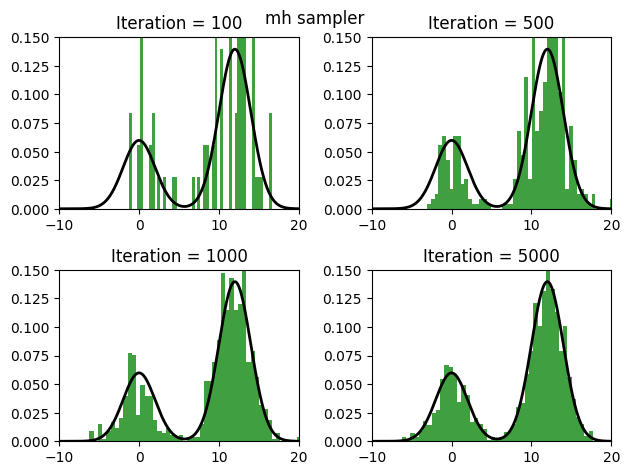

In [ ]:
#@title Evaluate the algorithm

#  Number of iterations/samples.
N = 5000 #@param {type:"integer"}


# Sampling algorithm
# - mh -> Metropolis-Hastings
# - slice -> Slice sampling
# - sa -> Simulated annealing (optimization)
sampler_name = "mh" #@param ["mh", "sa", "slice"]


# Hyperparameter for the proposal. Note that it has different meaning for
# MH or slice sampling.
sigma_prop = 10 #@param {type:"number"}


begin = time.process_time()
particles = mcmc(sampler_name, N, sigma_prop)

print("Time:", time.process_time()-begin)

plot_all(particles,221,N//50)
plot_all(particles,222,N//10)
plot_all(particles,223,N//5)
plot_all(particles,224,N)

pl.suptitle(sampler_name+' sampler')
pl.show()